In [1]:
import os
import random
import torch 
import shutil
from torchvision import datasets,transforms
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] =str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.determinitic = True 

In [2]:
def main(seed):
    seed_everything(seed)
    transform = transforms.ToTensor()
    train_data = datasets.MNIST(root='data', train=True,
                                       download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False,
                                      download=True, transform=transform)
    labelall = np.zeros(len(train_data)+len(test_data),dtype = 'int')
    datall = np.zeros((len(train_data)+len(test_data),28,28))
    for i in range(len(train_data)):
        datall[i,:,:] = np.expand_dims(train_data[i][0].numpy(),0)
        labelall[i] = train_data[i][1]
    for j in range(len(test_data)):
            #print(j)
        datall[len(train_data)+j,:,:] = np.expand_dims(test_data[j][0].numpy(),0)
            #print(j)
        labelall[len(train_data)+j] = int(test_data[j][1])
    print('We have total {} data instances'.format(len(datall)))
    
    if not os.path.exists('output_data'):
        os.mkdir('output_data')
    if not os.path.exists('output_solution'):
        os.mkdir('output_solution')

    
    x_train,x_test,y_train,y_test = train_test_split(datall,labelall,test_size = 0.2,random_state=seed)
    # trainning 56000  testing 14000
    
    
    testdata = x_test.astype('float32')
    testlabel = y_test
    
    cdata = testdata[:1400]
    clabel = testlabel[:1400]

    rdata = cdata[:1000]
    rlabel = clabel[:1000]
    fdata = cdata[1000:]
    flabel = clabel[1000:]

    cdata = None
    clabel = None
    
    rotationDegree = list(np.arange(0,360,45))
    #print(rotationDegree)
    augmendata = []
    for i,v in enumerate(rdata):
        seed = i%len(rotationDegree)
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.ToPILImage(),
                                        transforms.RandomRotation((rotationDegree[seed],rotationDegree[seed])),
                                        transforms.ToTensor()])
        a = transform(img=rdata[i]).numpy()
        augmendata.append(a)

    augmendata = np.array(augmendata).reshape(1000,28,28)
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([rdata, augmendata], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    #######################
    
    flipDegree = [0,1]

    augmendata2 = []
    for i,v in enumerate(fdata):
        seed = i%len(flipDegree)
        if seed == 0:
            transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(1),
                                        transforms.ToTensor()])

        else:
            transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.ToPILImage(),
                                        transforms.RandomVerticalFlip(1),
                                        transforms.ToTensor()])
        a = transform(img=fdata[i]).numpy()
        augmendata2.append(a)

    augmendata2 = np.array(augmendata2).reshape(400,28,28)
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([fdata, augmendata2], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    newtestdata = np.concatenate([testdata,augmendata,augmendata2],axis=0)
    newtestlabel = np.concatenate([testlabel,rlabel,flabel],axis=0)
    
    np.save('output_data/mnist.train.npy',x_train)
    np.save('output_data/mnist.test.npy',newtestdata)
    np.save('output_data/mnist.trainlabel.npy',y_train)

    submissiondict = {'id': list(range(1,(len(newtestlabel)+1))),
                      'class' : newtestlabel}
    df = pd.DataFrame(submissiondict)
    print(df.head())
    df.to_csv('output_solution/answer.csv',index=False) # This is the answer for HW 2

    sample = {'id': list(range(1,(len(newtestlabel)+1))),
                      'class' : list(np.random.randint(10,size=15400))}
    dfx = pd.DataFrame(sample)
    print(dfx.head())
    dfx.to_csv('output_data/sample_submission.csv',index=False)
    shutil.make_archive('MNIST_data','zip','output_data/')
    
    print('Finish!!')

We have total 70000 data instances
   id  class
0   1      1
1   2      2
2   3      9
3   4      8
4   5      5
   id  class
0   1      7
1   2      4
2   3      3
3   4      5
4   5      7
Finish!!


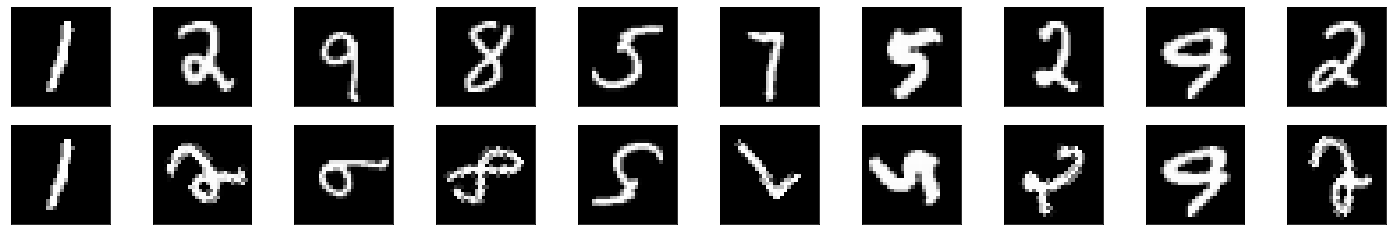

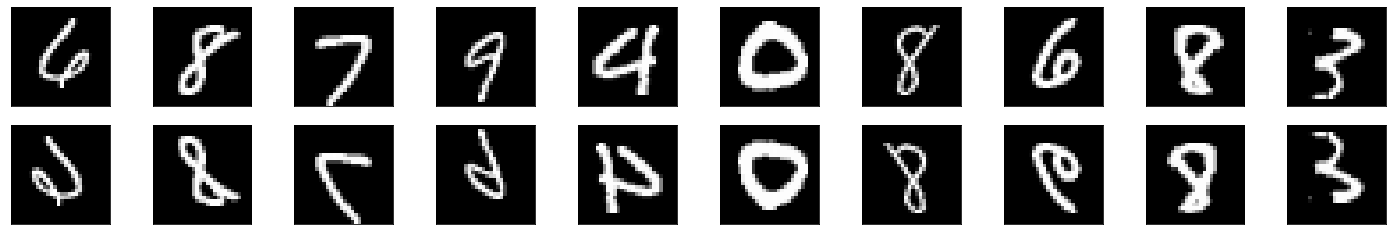

In [3]:
if __name__ == '__main__':
    main(224)